In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import cv2
import pandas as pd
from PIL import Image
from torchvision import transforms as T
import random
from skimage.util import random_noise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

000


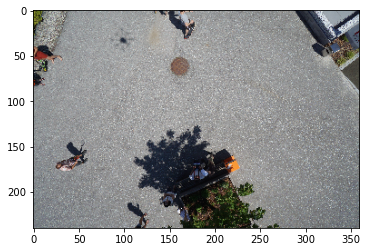

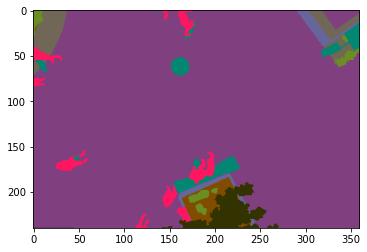

001


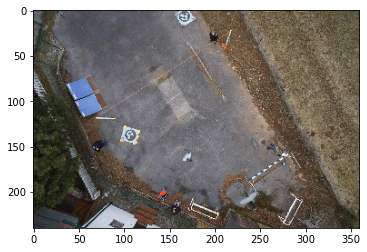

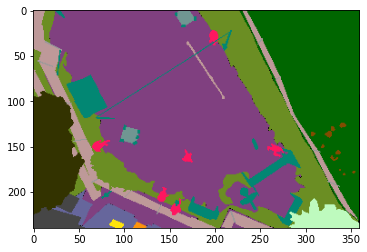

002


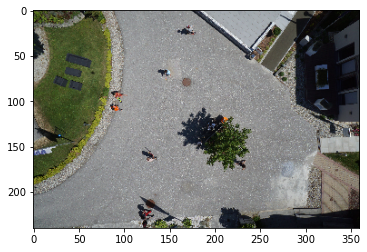

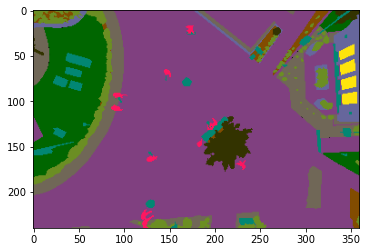

003
Flipped:


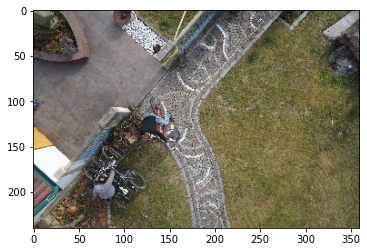

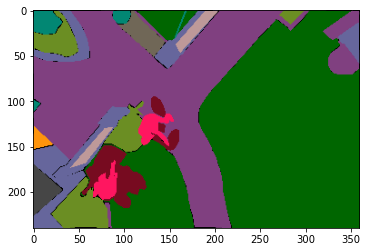

004
Flipped:


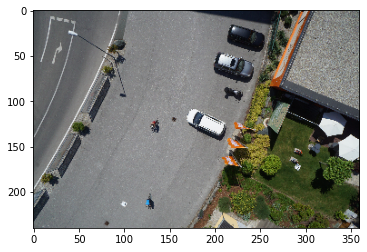

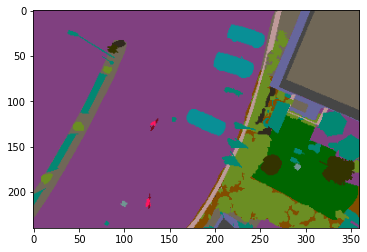

In [31]:
#Display Input and Target Images 
input_imgs_path = r"C:\Users\KARTIK BALI\Desktop\I2DL\archive\data\Drone_Semantic_Segmentation\dataset\semantic_drone_dataset\original_images"
target_imgs_path = r"C:\Users\KARTIK BALI\Desktop\I2DL\archive\data\Drone_Semantic_Segmentation\RGB_color_image_masks\RGB_color_image_masks"
rgb_mask_csv_path = r"C:\Users\KARTIK BALI\Desktop\I2DL\archive\data\Drone_Semantic_Segmentation\class_dict_seg.csv"
img_names = []
i = 0
for img_name in os.listdir(input_imgs_path)[:5]:
    print(img_name[:-4])
    input_img_name = img_name[:-4] + ".jpg"
    target_img_name = img_name[:-4] + ".png"
    img_names.append(img_name[:-4])
    input_img = Image.open(os.path.join(input_imgs_path,input_img_name))
    target_img = Image.open(os.path.join(target_imgs_path,target_img_name))
    
    input_img = T.ToTensor()(input_img)* 255
    target_img = T.ToTensor()(target_img)* 255
    
    input_img = T.Resize(240)(input_img) 
    target_img = T.Resize(240)(target_img)
    
    p = random.random()
    if p<=0.33:
        input_img = random_noise(input_img.numpy(),)
    
    if (random.random()>0.5):
        print("Flipped:")
        input_img = torch.flip(input_img,dims=[1])
        target_img = torch.flip(target_img,dims=[1])
    input_img = input_img.permute(1,2,0).numpy().astype(np.uint8)
    target_img = target_img.permute(1,2,0).numpy().astype(np.uint8)

    plt.imshow(input_img)
    plt.show()
    plt.imshow(target_img)
    plt.show()
    

def random_flip(input_img,target):
    if (random.random()>0.5):
        input_img = torch.flip(input_img,dims=[1])
        target = torch.flip(target,dims=[0])
    if (random.random()>0.5):
        input_img = torch.flip(input_img,dims=[2])
        target = torch.flip(target,dims=[1])
    return input_img,target
    

In [33]:
from torch.utils.data import Dataset
import cv2

    
class Aerial_Dataset(Dataset):
    def __init__(self,input_img_path,target_img_path,rgb_mask_csv_path):
        super().__init__()
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.rgb_mask_csv_path = rgb_mask_csv_path
        
        self.img_list = os.listdir(self.input_img_path)
        self.rgb_mask_df = pd.read_csv(self.rgb_mask_csv_path)
        
    def __len__(self):
        return(len(self.img_list))
    
    def __getitem__(self,index):
        input_img = Image.open(os.path.join(self.input_img_path,self.img_list[index]))
        target_img = cv2.imread(os.path.join(self.target_img_path,self.img_list[index][:-4]+".png"))
        
        input_img = T.ToTensor()(input_img)
        input_img = T.Resize(200)(input_img)
        input_img = T.CenterCrop(200)(input_img)
        
        target_img = target_img[:,1000:5001]
        target_img = cv2.resize(target_img,(200,200),interpolation=cv2.INTER_NEAREST)
        target_img = target_img[:,:,::-1]
        
        target_img = np.array(target_img,dtype=np.int64)
        #plt.imshow(target_img)
        #plt.show()
        np.set_printoptions(threshold=np.inf)
        #print('Before:')
        targets = target_img[...,0]
        #print(targets)
        for i in range(len(self.rgb_mask_df)):
            mask = np.all(target_img == self.rgb_mask_df.loc[i,['r','g','b']].values,axis=2)
            targets[mask] = int(self.rgb_mask_df.loc[i,"id"])
        
        #print("After:")
        #print(targets)
        targets = torch.from_numpy(targets.copy())
        targets = targets.type(torch.LongTensor)
        input_img,targets = random_flip(input_img,targets)
        #print(targets.shape)
        return input_img,targets
        

In [34]:
from torch.utils.data import DataLoader
trainable_data = Aerial_Dataset(input_imgs_path,target_imgs_path,rgb_mask_csv_path)
#print(trainable_data[5])
train_len = int(0.8 * len(trainable_data))
val_len = len(trainable_data) - train_len
train_data,val_data = torch.utils.data.random_split(trainable_data,[train_len,val_len])
batch_size = 16
train_dataloader = DataLoader(dataset = train_data, shuffle = True, batch_size = batch_size)
val_dataloader  = DataLoader(dataset = val_data, shuffle = True, batch_size = batch_size)

In [35]:
from torchvision import models
import torch.nn as nn
print(models.alexnet())
class U_net(nn.Module):
    def __init__(self,num_classes=23):
        super().__init__()
        self.num_classes = num_classes
        self.enc1 = models.alexnet(pretrained=True).features[:3]
        self.enc2 = models.alexnet(pretrained=True).features[3:6]
        self.enc3 = models.alexnet(pretrained=True).features[6:8]
        self.enc4 = models.alexnet(pretrained=True).features[8:10]
        self.enc5 = models.alexnet(pretrained=True).features[10:13]
        
        self.dec5 = nn.Sequential(nn.ConvTranspose2d(256,256,3,stride=2,padding=0),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU())
        self.dec4 = nn.Sequential(nn.Conv2d(512,384,3,stride=1,padding=1),
                                  nn.BatchNorm2d(384),
                                  nn.ReLU())
        
        self.dec3 = nn.Sequential(nn.Conv2d(384*2,192,3,stride=1,padding=1),
                                  nn.BatchNorm2d(192),
                                  nn.ReLU())
        
        '''
        self.dec3 = nn.Sequential(nn.Conv2d(384,192,3,stride=1,padding=1),
                                  nn.BatchNorm2d(192),
                                  nn.ReLU())
                                  '''
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(384,64,4,stride=2,padding=0),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(128,self.num_classes,18,stride=8,padding=1),
                                  nn.BatchNorm2d(self.num_classes),
                                  nn.ReLU())
          
        '''
        self.dec5 = nn.Sequential(nn.ConvTranspose2d(256,256,3,stride=2,padding=0),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU())
        self.dec4 = nn.Sequential(nn.Conv2d(256,384,3,stride=1,padding=1),
                                  nn.BatchNorm2d(384),
                                  nn.ReLU())
        
        self.dec3 = nn.Sequential(nn.Conv2d(384,192,3,stride=1,padding=1),
                                  nn.BatchNorm2d(192),
                                  nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(192,64,4,stride=2,padding=0),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(64,self.num_classes,18,stride=8,padding=1),
                                  nn.BatchNorm2d(self.num_classes),
                                  nn.ReLU())
        '''
    def forward(self,x):
        with torch.no_grad():
            x1 = self.enc1(x)
            x2 = self.enc2(x1)
            x3 = self.enc3(x2)
            x4 = self.enc4(x3)
            x5 = self.enc5(x4)
        
        x6 = self.dec5(x5)
        x7 = self.dec4(torch.cat((x6,x4),1))
        x8 = self.dec3(torch.cat((x7,x3),1))
        x9 = self.dec2(torch.cat((x8,x2),1))
        x10 = self.dec1(torch.cat((x9,x1),1))
        '''
        x6 = self.dec5(x5)
        x7 = self.dec4(x6+x4)
        x8 = self.dec3(x7+x3)
        x9 = self.dec2(x8+x2)
        x10 = self.dec1(x9+x1)'''
        
        return x10
                       
                       


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
num_classes = 23
model = U_net(num_classes)

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

loss_func = nn.CrossEntropyLoss(ignore_index=-1,reduction='mean')
optimizer = Adam(model.parameters(),lr=1e-3)
def train_loop(loss_fn,model,train_dataloader,optimizer,epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device('cpu')
    train_loss = 0
    model = model.to(device)
    for indx,batch in enumerate(train_dataloader):
        input_img,target_img = batch
        input_img,target_img = input_img.to(device),target_img.to(device)
        pred = model(input_img)
        loss = loss_fn(pred,target_img)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("=====",end='')
    print("")
    writer.add_scalar('Training loss',train_loss/len(train_dataloader),epoch)
    return train_loss/len(train_dataloader)
        
        
def val_loop(loss_fn,model,val_dataloader,epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device('cpu')
    val_loss = 0
    model = model.to(device)
    for indx, batch in enumerate(val_dataloader):
        input_img,target_img = batch
        input_img,target_img = input_img.to(device),target_img.to(device)
        pred = model(input_img)
        loss = loss_fn(pred,target_img)
        val_loss += loss.item()
        print("=====",end='')
    print("")
    writer.add_scalar('Validation loss',val_loss/len(val_dataloader),epoch)
    return val_loss/len(val_dataloader)
    

In [47]:
epochs = 1
for epoch in range(epochs):
    print("Epoch:",epoch+1)
    train_loss = train_loop(loss_func,model,train_dataloader,optimizer,epoch)
    val_loss = val_loop(loss_func,model,val_dataloader,epoch)
    print("")
    print(" train_loss:",format(train_loss,".5f"),", val_loss:",format(val_loss,".5f"))
    print("====================================================================================================")

Epoch: 1

 train_loss: 0.57149 , val_loss: 0.96357


In [48]:
def evaluate_model(model,dataloader):
    model.eval()
    score_list = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for input_img,target_img in dataloader:
        input_img,target_img = input_img.to(device),target_img.to(device)
        pred = model(input_img)
        _,pred_img = torch.max(pred,axis=1)
        mask = target_img >= 0
        score_list.append(np.mean( (pred_img.cpu()==target_img.cpu())[mask].numpy() ))
        print("=====",end='')
    print("")
    return(np.mean(score_list))
score_val = evaluate_model(model,val_dataloader)
print("model Accuracy:",score_val*100,"%")

model Accuracy: 75.73115151710668 %
